# Train Model with GPT architecture

In [1]:
# change working path to the current file
%cd ..

/home/hudongcheng/Desktop/bo_osda_generator


In [2]:
import numpy as np
import os
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.nn import functional as F
from tqdm import tqdm
from datetime import datetime
from torch.utils.tensorboard import SummaryWriter
import torch.backends.cudnn as cudnn

# import custom modules
from models.GPT import *
from utils.utils import *
from datasets.data_loader import *
from utils.plot_figures import *
from utils.metrics import *

In [3]:
cudnn.benchmark = True
cudnn.enabled = True

train_loss_history = []
train_acc_history = []
test_loss_history = []
test_acc_history = []

log_dir = './logs/'
save_best_weight_path = './checkpoints/'

now = datetime.now().strftime('%Y-%m-%d-%H-%M-%S')

In [4]:
# read the data and convert to the format we need
train_smiles = read_strings('./data/train_smiles.csv', idx=False)
train_zeo = read_vec('./data/train_zeo.csv', idx=False)
train_syn = read_vec('./data/train_syn.csv', idx=False)
train_codes = read_strings('./data/train_codes.csv', idx=False)
test_smiles = read_strings('./data/test_smiles.csv', idx=False)
test_zeo = read_vec('./data/test_zeo.csv', idx=False)
test_syn = read_vec('./data/test_syn.csv', idx=False)
test_codes = read_strings('./data/test_codes.csv', idx=False)

charset = '?P25$]FO-S.Hc=71(ln63NC4[+)^@'
charlen = len(charset)
print('the charset(inculde begin end and pad char) achieved from dataset :', charset)
print('the total num of charset is :', charlen)
# create the char to index and index to char dictionary
char_to_index = dict((c, i) for i, c in enumerate(charset))
index_to_char = dict((i, c) for i, c in enumerate(charset))
char_list = [k for k, v in char_to_index.items()]

the charset(inculde begin end and pad char) achieved from dataset : ?P25$]FO-S.Hc=71(ln63NC4[+)^@
the total num of charset is : 29


In [5]:
# hyperparameters
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
batch_size = 512
epoch = 20
seqlen = 127

In [6]:
src_smiles, tgt_smiles = smiles_padding(train_smiles)
tgt_seq = smiles_to_sequence(tgt_smiles, char_to_index)
tgt_seq = torch.cat([torch.unsqueeze(seq, 0) for seq in tgt_seq]).long()
src_smiles_test, tgt_smiles_test = smiles_padding(test_smiles)
tgt_seq_test = smiles_to_sequence(tgt_smiles_test, char_to_index)
tgt_seq_test = torch.cat([torch.unsqueeze(seq, 0) for seq in tgt_seq_test]).long()
# create the dataset and dataloader
train_dataset = SeqDataset(train_zeo, train_syn, tgt_seq)
test_dataset = SeqDataset(test_zeo, test_syn, tgt_seq_test)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
# create the model
config = GPTConfig(vocab_size=charlen, block_size=128, num_props=24)
model = GPT(config).to(device)
# loss
loss_func = torch.nn.CrossEntropyLoss(ignore_index=char_to_index['?'])
optim = torch.optim.Adam(model.parameters(), lr=6e-4)
total = sum(p.numel() for p in model.parameters())
print('total parameters: %0.2fM' % (total / 1e6))

total parameters: 3.21M


In [7]:
# train function
def train(model, train_dataloader, loss_func, optim, device):
    model.train()
    total_loss = 0
    total_acc = 0
    total_num = 0
    for i, (zeo, syn, tgt) in enumerate(tqdm(train_dataloader)):
        zeo = zeo.to(device)
        syn = syn.to(device)
        tgt = tgt.to(device)
        # concat zeo and syn as the input (prop)
        synthesis_condition = torch.cat([zeo, syn], dim=-1)
        tgt_input = tgt[:, :-1].contiguous()
        tgt_label = tgt[:, 1:].contiguous()
        
        # forward
        optim.zero_grad()
        output = model(idx=tgt_input, prop=synthesis_condition)
        loss = loss_func(output.view(-1, output.size(-1)), tgt_label.view(-1))
        
        # calculate the accuracy
        pred = torch.argmax(output, dim=-1)
        num_correct = (pred == tgt_label) & (tgt_label != char_to_index['?'])
        num_words = (tgt_label != char_to_index['?']).sum().item()
        
        # backward
        loss.backward()
        optim.step()
        
        total_loss += loss.item()
        total_acc += num_correct.sum().item()
        total_num += num_words
    return total_loss / len(train_dataloader), total_acc / total_num

In [8]:
def evaluate(model, test_dataloader, loss_func, device):
    model.eval()
    total_loss = 0
    total_acc = 0
    total_num = 0
    with torch.no_grad():
        for i, (zeo, syn, tgt) in enumerate(tqdm(test_dataloader)):
            zeo = zeo.to(device)
            syn = syn.to(device)
            tgt = tgt.to(device)
            # concat zeo and syn as the input (prop)
            synthesis_condition = torch.cat([zeo, syn], dim=-1)
            tgt_input = tgt[:, :-1].contiguous()
            tgt_label = tgt[:, 1:].contiguous()
            # forward
            output = model(idx=tgt_input, prop=synthesis_condition)
            loss = loss_func(output.view(-1, output.size(-1)), tgt_label.view(-1))
            # calculate the accuracy
            pred = torch.argmax(output, dim=-1)
            num_correct = (pred == tgt_label) & (tgt_label != char_to_index['?'])
            num_words = (tgt_label != char_to_index['?']).sum().item()
            total_loss += loss.item()
            total_acc += num_correct.sum().item()
            total_num += num_words
    return total_loss / len(test_dataloader), total_acc / total_num

In [9]:
# train the model
for i in range(epoch):
    train_loss, train_acc = train(model, train_dataloader, loss_func, optim, device)
    train_loss_history.append(train_loss)
    train_acc_history.append(train_acc)
    print('epoch: %d, train loss: %.4f, train acc: %.4f' % (i, train_loss, train_acc))
    test_loss, test_acc = evaluate(model, test_dataloader, loss_func, device)
    test_loss_history.append(test_loss)
    test_acc_history.append(test_acc)
    print('epoch: %d test loss: %.4f, test acc: %.4f' % (i, test_loss, test_acc))
    if i == 0:
        best_acc = test_acc
    if test_acc > best_acc:
        best_acc = test_acc
        torch.save(model.state_dict(), save_best_weight_path + 'best_GPT_model.pth')
    torch.save(model.state_dict(), save_best_weight_path + 'last_GPT_model.pth')

100%|██████████| 284/284 [00:29<00:00,  9.60it/s]


epoch: 0, train loss: 1.1359, train acc: 0.6230


100%|██████████| 68/68 [00:02<00:00, 29.45it/s]


epoch: 0 test loss: 0.7461, test acc: 0.7218


100%|██████████| 284/284 [00:29<00:00,  9.67it/s]


epoch: 1, train loss: 0.6836, train acc: 0.7418


100%|██████████| 68/68 [00:02<00:00, 29.39it/s]


epoch: 1 test loss: 0.5995, test acc: 0.7691


100%|██████████| 284/284 [00:29<00:00,  9.69it/s]


epoch: 2, train loss: 0.5698, train acc: 0.7786


100%|██████████| 68/68 [00:02<00:00, 28.96it/s]


epoch: 2 test loss: 0.5438, test acc: 0.7873


100%|██████████| 284/284 [00:29<00:00,  9.68it/s]


epoch: 3, train loss: 0.5077, train acc: 0.7991


100%|██████████| 68/68 [00:02<00:00, 28.98it/s]


epoch: 3 test loss: 0.4627, test acc: 0.8152


100%|██████████| 284/284 [00:29<00:00,  9.67it/s]


epoch: 4, train loss: 0.4528, train acc: 0.8170


100%|██████████| 68/68 [00:02<00:00, 29.33it/s]


epoch: 4 test loss: 0.4157, test acc: 0.8309


100%|██████████| 284/284 [00:29<00:00,  9.66it/s]


epoch: 5, train loss: 0.4185, train acc: 0.8282


100%|██████████| 68/68 [00:02<00:00, 29.32it/s]


epoch: 5 test loss: 0.3891, test acc: 0.8380


100%|██████████| 284/284 [00:29<00:00,  9.67it/s]


epoch: 6, train loss: 0.3919, train acc: 0.8369


100%|██████████| 68/68 [00:02<00:00, 29.33it/s]


epoch: 6 test loss: 0.3714, test acc: 0.8437


100%|██████████| 284/284 [00:29<00:00,  9.67it/s]


epoch: 7, train loss: 0.3714, train acc: 0.8439


100%|██████████| 68/68 [00:02<00:00, 28.99it/s]


epoch: 7 test loss: 0.3504, test acc: 0.8507


100%|██████████| 284/284 [00:29<00:00,  9.68it/s]


epoch: 8, train loss: 0.3553, train acc: 0.8490


100%|██████████| 68/68 [00:02<00:00, 28.97it/s]


epoch: 8 test loss: 0.3429, test acc: 0.8531


100%|██████████| 284/284 [00:29<00:00,  9.67it/s]


epoch: 9, train loss: 0.3428, train acc: 0.8533


100%|██████████| 68/68 [00:02<00:00, 28.96it/s]


epoch: 9 test loss: 0.3295, test acc: 0.8568


100%|██████████| 284/284 [00:29<00:00,  9.68it/s]


epoch: 10, train loss: 0.3318, train acc: 0.8566


100%|██████████| 68/68 [00:02<00:00, 29.36it/s]


epoch: 10 test loss: 0.3208, test acc: 0.8599


100%|██████████| 284/284 [00:29<00:00,  9.66it/s]


epoch: 11, train loss: 0.3222, train acc: 0.8597


100%|██████████| 68/68 [00:02<00:00, 29.40it/s]


epoch: 11 test loss: 0.3192, test acc: 0.8598


100%|██████████| 284/284 [00:29<00:00,  9.67it/s]


epoch: 12, train loss: 0.3162, train acc: 0.8616


100%|██████████| 68/68 [00:02<00:00, 28.95it/s]


epoch: 12 test loss: 0.3138, test acc: 0.8607


100%|██████████| 284/284 [00:29<00:00,  9.67it/s]


epoch: 13, train loss: 0.3081, train acc: 0.8643


100%|██████████| 68/68 [00:02<00:00, 29.29it/s]


epoch: 13 test loss: 0.3055, test acc: 0.8637


100%|██████████| 284/284 [00:29<00:00,  9.66it/s]


epoch: 14, train loss: 0.3031, train acc: 0.8661


100%|██████████| 68/68 [00:02<00:00, 28.95it/s]


epoch: 14 test loss: 0.3033, test acc: 0.8645


100%|██████████| 284/284 [00:29<00:00,  9.68it/s]


epoch: 15, train loss: 0.2982, train acc: 0.8677


100%|██████████| 68/68 [00:02<00:00, 29.01it/s]


epoch: 15 test loss: 0.2967, test acc: 0.8659


100%|██████████| 284/284 [00:29<00:00,  9.68it/s]


epoch: 16, train loss: 0.2936, train acc: 0.8690


100%|██████████| 68/68 [00:02<00:00, 29.38it/s]


epoch: 16 test loss: 0.3033, test acc: 0.8644


100%|██████████| 284/284 [00:29<00:00,  9.67it/s]


epoch: 17, train loss: 0.2899, train acc: 0.8701


100%|██████████| 68/68 [00:02<00:00, 29.33it/s]


epoch: 17 test loss: 0.2909, test acc: 0.8678


100%|██████████| 284/284 [00:29<00:00,  9.67it/s]


epoch: 18, train loss: 0.2864, train acc: 0.8714


100%|██████████| 68/68 [00:02<00:00, 29.34it/s]


epoch: 18 test loss: 0.2921, test acc: 0.8677


100%|██████████| 284/284 [00:29<00:00,  9.67it/s]


epoch: 19, train loss: 0.2837, train acc: 0.8723


100%|██████████| 68/68 [00:02<00:00, 28.99it/s]


epoch: 19 test loss: 0.2888, test acc: 0.8684


In [10]:
def generate_gpt(model, start_sequence, condition_props, max_length, char_to_index, index_to_char, device, temperature=1.0, top_k=0):
    """
    Autoregressive generation process for a GPT model.

    Args:
        model (GPT): The pre-trained GPT model for token generation.
        start_sequence (torch.Tensor): The initial sequence to start generation (batch_size, seq_length).
        condition_props (torch.Tensor): The conditional property vector (batch_size, num_props).
        max_length (int): The maximum length of the generated sequence.
        char_to_index (dict): A mapping from characters to their corresponding indices.
        index_to_char (dict): A mapping from indices to their corresponding characters.
        device (torch.device): The device on which to run the generation.
        temperature (float): Temperature parameter for sampling; higher values increase randomness.
        top_k (int): Limits sampling to top-k logits; if 0, no top-k sampling is applied.

    Returns:
        List[str]: A list of generated SMILES strings.
    """
    model.eval()
    batch_size = start_sequence.size(0)
    generated_sequences = start_sequence.clone().to(device)  # Clone and move to device

    for _ in range(max_length - start_sequence.size(1)):
        # Get the current sequence length
        current_length = generated_sequences.size(1)

        # Forward pass through the model
        logits = model(generated_sequences, condition_props)  # (batch_size, seq_length, vocab_size)

        # Extract the logits for the last time step
        next_token_logits = logits[:, -1, :]  # (batch_size, vocab_size)

        # Apply temperature scaling
        next_token_logits = next_token_logits / temperature

        # Apply top-k filtering
        if top_k > 0:
            top_k_logits, top_k_indices = torch.topk(next_token_logits, top_k, dim=-1)
            mask = torch.full_like(next_token_logits, float('-inf'))
            mask.scatter_(dim=-1, index=top_k_indices, src=top_k_logits)
            next_token_logits = mask

        # Convert logits to probabilities
        next_token_probs = F.softmax(next_token_logits, dim=-1)

        # Sample from the probability distribution
        next_token = torch.multinomial(next_token_probs, num_samples=1)  # (batch_size, 1)
        
        # Get the most likely next token
        # next_token = torch.argmax(next_token_logits, dim=-1, keepdim=True)

        # Append the generated token to the sequence
        generated_sequences = torch.cat([generated_sequences, next_token], dim=1)

        # Check if all sequences have reached the end token ('$')
        if all(next_token[i].item() == char_to_index['$'] for i in range(batch_size)):
            break

    # Decode the generated sequences into SMILES strings
    generated_smiles = []
    for seq in generated_sequences:
        # Convert indices to characters, ignoring padding ('?') and start ('^') tokens
        # check if the generated sequence contains the end token ('$'), if meet, stop decoding
        smiles = ''
        for idx in seq:
            if idx.item() == char_to_index['$']:
                break
            elif idx.item() != char_to_index['?'] and idx.item() != char_to_index['^']:
                smiles += index_to_char[idx.item()]
        generated_smiles.append(smiles)

    return generated_smiles


In [11]:
# test the generate function
# check the first 10 samples
train_zeo_vec = train_zeo[:10].astype(np.float32)
train_syn_vec = train_syn[:10].astype(np.float32)
zeo = torch.tensor(train_zeo_vec, dtype=torch.float32).to(device)
syn = torch.tensor(train_syn_vec, dtype=torch.float32).to(device)
target_smi = train_smiles[:10]
# start_sequence = torch.full((10, 1), char_to_index['^'], dtype=torch.long)
# get the first two characters as the start sequence

start_sequence = tgt_seq[:10, :2]
start_sequence = start_sequence.to(device)
condition_synthesis = torch.cat([zeo, syn], dim=1)
print('start sequence:', start_sequence.size())
print('condition synthesis:', condition_synthesis.size())
generated_smiles = generate_gpt(model, start_sequence, condition_synthesis, seqlen, char_to_index, index_to_char, device, 0.5)
print('target smiles:')
print(target_smi)
print('generated smiles:')
print(generated_smiles)

start sequence: torch.Size([10, 2])
condition synthesis: torch.Size([10, 24])
target smiles:
[['n1(C)c(C)[n+](cc1)Cc1ccccc1C[n+]1ccn(C)c1C']
 ['Cn1cc[n+](Cc2ccccc2C[n+]2ccn(C)c2C)c1C']
 ['Cc1n(C)cc[n+]1Cc1c(cccc1)C[n+]1ccn(c1C)C']
 ['c1ccc(c(c1)C[n+]1c(C)n(C)cc1)C[n+]1ccn(c1C)C']
 ['[n+]1(c(n(C)cc1)C)Cc1c(C[n+]2ccn(c2C)C)cccc1']
 ['Cc1n(C)cc[n+]1Cc1ccccc1C[n+]1c(n(cc1)C)C']
 ['Cn1c(C)[n+](cc1)Cc1ccccc1C[n+]1ccn(c1C)C']
 ['c1c[n+](Cc2ccccc2C[n+]2c(C)n(cc2)C)c(C)n1C']
 ['n1(cc[n+](c1C)Cc1ccccc1C[n+]1ccn(C)c1C)C']
 ['[n+]1(Cc2c(C[n+]3c(n(cc3)C)C)cccc2)c(C)n(C)cc1']]
generated smiles:
['n1(c([n+](cc1)Cc1ccc(cc1)C[n+]1c(C)n(cc1)C)C)C', 'C1CCC(C)C[N+]21Cc1c(cccc1)C2', 'C1CC(CC[N+]21Cc1c(C2)cccc1)C', 'c1cccc2c1C[N+]1(C2)CCCCC1C', '[n+]1(Cc2cccc(C[n+]3ccn(C)c3C)c2)c(C)n(C)cc1', 'C1CCCC(C)[N+]21Cc1c(C2)cccc1', 'C1[N+]2(CCCCC2)Cc2ccccc21', 'c1cccc2c1C[N+]1(C2)CC(CC(C)C1)C', 'n1(c(C)[n+](Cc2cccc(C[n+]3c(C)n(C)cc3)c2)cc1)C', '[n+]1(c(C)n(cc1)C)Cc1ccc(cc1)C[n+]1ccn(C)c1C']


In [12]:
# generate the smiles for the test dataset
generated_smile = []
target_smile = []
for i, (zeo, syn, tgt) in enumerate(tqdm(test_dataloader)):
    zeo = zeo.to(device)
    syn = syn.to(device)
    tgt = tgt.to(device)
    condition_synthesis = torch.cat([zeo, syn], dim=1)
    generated_smiles = generate_gpt(model, tgt[:, :2], condition_synthesis, seqlen, char_to_index, index_to_char, device, 0.5)
    generated_smile.extend(generated_smiles)
    # convert the tgt to smiles
    tgt_smiles = []
    for seq in tgt:
        smiles = ''
        for idx in seq:
            if idx.item() == char_to_index['$']:
                break
            elif idx.item() != char_to_index['?'] and idx.item() != char_to_index['^']:
                smiles += index_to_char[idx.item()]
        tgt_smiles.append(smiles)
    target_smile.extend(tgt_smiles)

100%|██████████| 68/68 [02:37<00:00,  2.32s/it]


In [13]:
# calculate the metrics
print('Validity rate:', validity_rate(generated_smiles))
print('Uniqueness rate:', uniqueness_rate(generated_smiles))
print('Novelty rate:', novelty_rate(generated_smiles, target_smi))
print('Reconstructability rate:', reconstructability_rate(generated_smiles, target_smi))
print('Novelty rate:', novelty_rate(generated_smiles, target_smi))
print('IntDiv:', IntDiv(generated_smiles))
# print('KL-divergence:', KL_divergence(target_smi, generated_smile))
print('FCD score:', FCD_score(target_smile, generated_smile))

[17:16:11] SMILES Parse Error: unclosed ring for input: 'c1cc2c(cc1)C[N+]1(C2)CCCCC1CCCC2'
[17:16:11] SMILES Parse Error: unclosed ring for input: 'c1cccc2c1C[N+]1(C2)CCCCC1CCCC1'
[17:16:11] SMILES Parse Error: unclosed ring for input: 'c1cccc2c1C[N+]1(C2)CCCCC1CCCC1'
[17:16:11] SMILES Parse Error: unclosed ring for input: 'C1CCC2CC3[N+]4(C(CC(C3)[N+]2(C)CCC1)C)C'
[17:16:11] SMILES Parse Error: unclosed ring for input: 'C1CC2CC3[N+](C)(CCCC3)C1CC1CCCCN2'
[17:16:11] SMILES Parse Error: unclosed ring for input: 'C1[N+]2(CCCCC2CC2CC1CC1CCCCN2)C'
[17:16:11] SMILES Parse Error: unclosed ring for input: 'c1cc2c(cc1)C[N+]1(C2)CCCCC1CCCC2'
[17:16:11] SMILES Parse Error: unclosed ring for input: 'c1cccc2c1C[N+]1(C2)CCCCC1CCCC1'
[17:16:11] SMILES Parse Error: unclosed ring for input: 'c1cccc2c1C[N+]1(C2)CCCCC1CCCC1'
[17:16:11] SMILES Parse Error: unclosed ring for input: 'C1CCC2CC3[N+]4(C(CC(C3)[N+]2(C)CCC1)C)C'
[17:16:11] SMILES Parse Error: unclosed ring for input: 'C1CC2CC3[N+](C)(CCCC3)C1CC1

Validity rate: 0.988
Uniqueness rate: 0.744
Novelty rate: 1.0
Reconstructability rate: 0.0
Novelty rate: 1.0
IntDiv: 0.770296973479559


[17:16:14] Can't kekulize mol.  Unkekulized atoms: 26 27 28 29 30
[17:16:14] SMILES Parse Error: unclosed ring for input: 'C12CC(CC(C[n+]3cn(C4C5CC(C5)CC(C6)C5)cc3)C2)CC1'
[17:16:14] SMILES Parse Error: unclosed ring for input: 'C1C2C3C[N+](CC3C(C=1)C1C2C[N+](CC12)(CC)CC)(CC)CC'
[17:16:14] Can't kekulize mol.  Unkekulized atoms: 0 1 11 12 13 14 15
[17:16:15] SMILES Parse Error: unclosed ring for input: 'C1C2C3C[N+](CC3C(C=1)C1C2C[N+](CC12)(CC)CC)(CC)CC'
[17:16:15] SMILES Parse Error: extra open parentheses for input: 'C1CCC23CC(CC3(CC([N+](C)(C)C)C2)CC1[N+](C)(C)C'
[17:16:15] SMILES Parse Error: unclosed ring for input: 'C1CC2CC3[N+]4(CC)C(CC(C3)N2CCC1)CC'
[17:16:15] SMILES Parse Error: extra close parentheses while parsing: C1C[N+](CC)(CC)CC2C1C1C=CC2C2C[N+](CC)(CC12)CC)CC
[17:16:15] SMILES Parse Error: Failed parsing SMILES 'C1C[N+](CC)(CC)CC2C1C1C=CC2C2C[N+](CC)(CC12)CC)CC' for input: 'C1C[N+](CC)(CC)CC2C1C1C=CC2C2C[N+](CC)(CC12)CC)CC'
[17:16:15] SMILES Parse Error: unclosed ring fo

FCD score: 0.18165066915429762


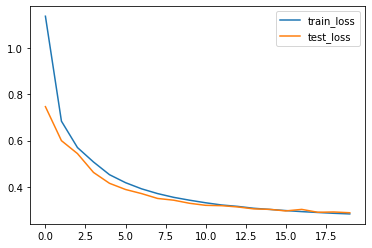

In [14]:
# plot the loss and acc
plot_loss(train_loss_history, test_loss_history, 'GPT')